In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# all parameters are specified once at the start, grouped together nicely
# the signature of most functions is simplified
# ???
# should compute_selection_map be private
# in general, which methods should be private?
# should i, j belong to the class
# should random_state belong to the class

# smells that remain
# need to do the bookkeeping for i, j in case you want to create / simulate entire trajectories
# changing the next step probability is going to be trouble
# adding a new activation map requires adding a new piece to the code
# what if map_type is not any of the 3?


class Walker:

    def __init__(self, sigma_i, sigma_j, size, map_type='flat'):
        self.sigma_i = sigma_i
        self.sigma_j = sigma_j
        self.size = size

        if map_type == 'flat':
            activation_map = np.ones((size, size))
        elif map_type == 'hills':
            grid_ii, grid_jj = np.mgrid[0:size, 0:size]
            i_waves = np.sin(grid_ii/130) + np.sin(grid_ii/10)
            i_waves /= i_waves.max()
            j_waves = np.sin(grid_jj/100) + np.sin(grid_jj/50)+ np.sin(grid_jj/10)
            j_waves /= j_waves.max()
            activation_map = j_waves+i_waves
        elif map_type == 'labyrinth':
            activation_map = np.ones((size, size))
            activation_map[50:100, 50:60] = 0
            activation_map[20:89, 80:90] = 0
            activation_map[90:120, 0:10] = 0
            activation_map[120:size, 30:40] = 0
            activation_map[180:190, 50:60] = 0

            activation_map[50:60, 50:200] = 0
            activation_map[179:189, 80:130] = 0
            activation_map[110:120, 0:190] = 0
            activation_map[120:size, 30:40] = 0
            activation_map[180:190, 50:60] = 0
        activation_map /= activation_map.sum()
        self.activation_map = activation_map

        self._grid_ii, self._grid_jj = np.mgrid[0:size, 0:size]

    def next_step_probability(self, current_i, current_j):
        grid_ii, grid_jj = self._grid_ii, self._grid_jj
        sigma_i, sigma_j = self.sigma_i, self.sigma_j

        rad = (
            (((grid_ii - current_i) ** 2) / (sigma_i ** 2))
            + (((grid_jj - current_j) ** 2)/ (sigma_j ** 2))
        )

        p_next_step = np.exp(-(rad / 2.0)) / (2.0 * np.pi * sigma_i * sigma_j)
        return p_next_step / p_next_step.sum()

    def _compute_selection_map(self, next_step_map):
        selection_map = next_step_map * self.activation_map
        selection_map /= selection_map.sum()
        return selection_map

    def sample_next_step(self, current_i, current_j, random_state=np.random):
        next_step_map = self.next_step_probability(current_i, current_j)
        selection_map = self._compute_selection_map(next_step_map)

        r = random_state.rand()
        cumulative_map = np.cumsum(selection_map)
        cumulative_map = cumulative_map.reshape(selection_map.shape)
        i_next, j_next = np.argwhere(cumulative_map >= r)[0]

        return i_next, j_next

    def evaluate_position(self, current_i, current_j):
        next_step_map = self.next_step_probability(current_i, current_j)
        selection_map = self._compute_selection_map(next_step_map)
        return selection_map[current_i, current_j]


In [6]:
walker = Walker(
    sigma_i=3,
    sigma_j=4,
    size=200,
    map_type='labyrinth',
)

i, j = 100, 50
trajectory = []
for _ in range(1000):
    i, j = walker.sample_next_step(i, j)
    trajectory.append((i, j))

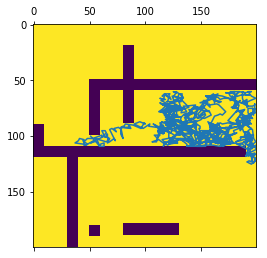

In [8]:
trajectory = np.array(trajectory)
plt.matshow(walker.activation_map)
plt.plot(trajectory[:, 1], trajectory[:, 0])